In [1]:
# 드라이브에 접근할 수 있도록 아래 코드 입력
# from google.colab import drive
# drive.mount('/content/drive')

# 프로토타입

1. 데이터 수집 & 탐색

  - 전체 통계량 & 중요 통계량 확인

2. 추천 엔진

  - 유사 아이템 찾기

3. 추천 모듈 구현

  - 간단 -> 복잡

4. 성능 평가


# 무비렌즈 데이터
+ 추천 시스템에 사용될 모델 학습에선 데이터가 필수!
+ 무비렌즈 데이터를 추천 모델 학습에 필요한 형태로 `가공`해봄

## 랭킹(Ranking)

+ 유저에게 적합한 아이템 Top K개를 추천
+ Top K개를 선정하기 위한 기준 혹은 `Score`가 필요하지만, 유저`X`가 아이템 `Y`에 가지는 **정확한 선호도를 구할 필요 X**<br>
_평가 지표 : Precision@K, Recall@K, MAP@K, nDCG@K_


## 데이터 특징
+ 유저가 영화에게 준 평점 데이터가 있음
+ 영화에 대한 제목, 장르, 연도 등이 있음
+ 유저에 대한 성별, 연령, 직업, 주소 등이 있음
+ **Explicit Feedback** : 선호도 1.0 ~ 5.0 사이의 점수로 표현

### 헤더 선언

In [2]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 데이터 초기화

In [3]:
# path = '/content/drive/MyDrive/Colab Notebooks/42Bigdata/4-2/' # '/data/ml-100k'
path = './'

ratings_df = pd.read_csv(path + 'u.data', sep='\t', encoding='latin-1', header=None)
movies_df = pd.read_csv(path + 'u.item', sep='|', encoding='latin-1', header=None)
users_df = pd.read_csv(path + 'u.user', sep='|', encoding='latin-1', header=None)

ratings_df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movies_df.columns =  ['movie_id', 'movie_title', 'release_date', 'video_release_date',
                     'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 
                     'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                     'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                     'Thriller', 'War', 'Western']
users_df.columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

+ timestamp를 datetime으로 변경!
+ 추천 문제에서 보통 과거 데이터를 `학습`해서 현재, 미래에 추천하기 때문에 `시간`은 **트레이닝 데이터와 테스트 데이터를 나눌 때** 매우 중요

In [4]:
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['date'] = ratings_df['datetime'].dt.strftime('%Y-%m-%d').astype(str)

In [5]:
print(ratings_df)

       user_id  movie_id  rating  timestamp            datetime        date
0          196       242       3  881250949 1997-12-04 15:55:49  1997-12-04
1          186       302       3  891717742 1998-04-04 19:22:22  1998-04-04
2           22       377       1  878887116 1997-11-07 07:18:36  1997-11-07
3          244        51       2  880606923 1997-11-27 05:02:03  1997-11-27
4          166       346       1  886397596 1998-02-02 05:33:16  1998-02-02
...        ...       ...     ...        ...                 ...         ...
99995      880       476       3  880175444 1997-11-22 05:10:44  1997-11-22
99996      716       204       5  879795543 1997-11-17 19:39:03  1997-11-17
99997      276      1090       1  874795795 1997-09-20 22:49:55  1997-09-20
99998       13       225       2  882399156 1997-12-17 22:52:36  1997-12-17
99999       12       203       3  879959583 1997-11-19 17:13:03  1997-11-19

[100000 rows x 6 columns]


### 평점 데이터의 기초 통계량


+ 데이터에 대한 기본적인 통계 정보를 확인
  - 데이터를 크롤링해왔으면 전체 기초 통계량의 확인 필수!
+ 몇가지 정보에 대해서 `Visualization`

In [6]:
n_user = len(ratings_df['user_id'].unique())    # 유저 수
n_movie = len(ratings_df['movie_id'].unique())    # 영화 수

print('유저 수 :', n_user, '영화 수 :', n_movie)

# 평점 데이터 정보
ratings_df.info()

유저 수 : 943 영화 수 : 1682
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    100000 non-null  int64         
 1   movie_id   100000 non-null  int64         
 2   rating     100000 non-null  int64         
 3   timestamp  100000 non-null  int64         
 4   datetime   100000 non-null  datetime64[ns]
 5   date       100000 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 4.6+ MB


In [7]:
# pandas에서 제공하는 기초 통계량, 열 이름 잘못 적으면 오류!
ratings_df[['user_id', 'movie_id', 'rating']].describe()

,user_id,movie_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


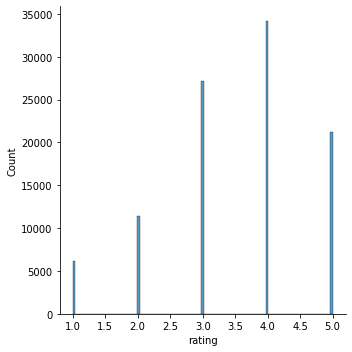

In [8]:
# 평점 데이터 분포
sns.displot(ratings_df['rating'])

In [9]:
# 사용자 별로 aggregate한 데이터 확인
user_stastics = pd.DataFrame({
    'numRating' : ratings_df.groupby('user_id')['movie_id'].nunique(),
    'avgRating' : ratings_df.groupby('user_id')['rating'].mean(),
    'stdRating' : ratings_df.groupby('user_id')['rating'].std(),
}).reset_index()

user_stastics.head()

,user_id,numRating,avgRating,stdRating
0,1,272,3.610294,1.263585
1,2,62,3.709677,1.030472
2,3,54,2.796296,1.219026
3,4,24,4.333333,0.916831
4,5,175,2.874286,1.362963


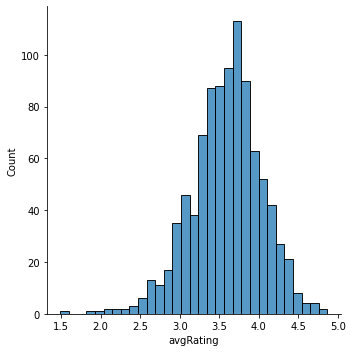

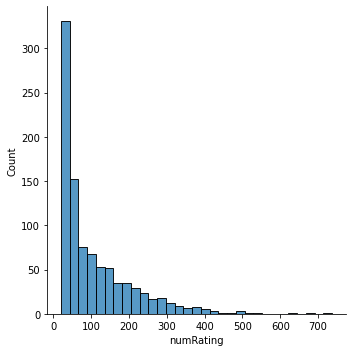

In [10]:
# 사용자의 평점 분포
# print('{0:=^43}'.format('사용자의 평점 분포'))
sns.displot(user_stastics['avgRating'])

# 사용자 평가 영화 개수 분포
sns.displot(user_stastics['numRating'])

### 인기도 기반 영화 추천(Popular, Highly Rated)

+ Popular : 가장 많은 유저가 본 영화(혹은 평가를 받은)
+ Highly Rated : 가장 높은 평점을 받은 영화

In [11]:
# 영화 Ranking을 위한 영화별 통계량 계산

movie_statistics = pd.DataFrame({
    'numUsers': ratings_df.groupby('movie_id')['user_id'].nunique(),
    'avgRating': ratings_df.groupby('movie_id')['rating'].mean(), 
    'stdRating': ratings_df.groupby('movie_id')['rating'].std()
}).reset_index()

movie_statistics.head()

,movie_id,numUsers,avgRating,stdRating
0,1,452,3.878319,0.927897
1,2,131,3.206107,0.966497
2,3,90,3.033333,1.212760
3,4,209,3.550239,0.965069
4,5,86,3.302326,0.946446


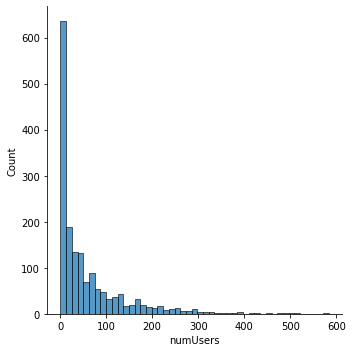

In [12]:
# 영화별 평가 개수 분포
sns.displot(movie_statistics['numUsers'])

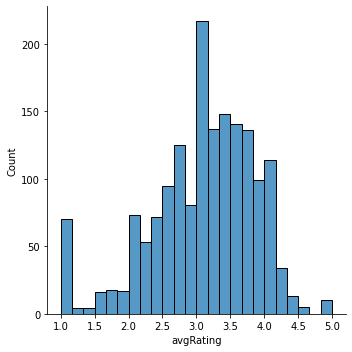

In [13]:
# 영화별 평균 평점의 분포
sns.displot(movie_statistics['avgRating'])

### Popular


In [14]:
# 가장 많은 유저가 본 영화 Top 10
top10_df = movie_statistics.sort_values(by='numUsers', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,movie_id,numUsers,avgRating,stdRating,movie_title,release_date
0,50,583,4.358491,0.881341,Star Wars (1977),01-Jan-1977
1,258,509,3.803536,0.994427,Contact (1997),11-Jul-1997
2,100,508,4.155512,0.975756,Fargo (1996),14-Feb-1997
3,181,507,4.007890,0.923955,Return of the Jedi (1983),14-Mar-1997
4,294,485,3.156701,1.098544,Liar Liar (1997),21-Mar-1997
5,286,481,3.656965,1.169401,"English Patient, The (1996)",15-Nov-1996
6,288,478,3.441423,1.113910,Scream (1996),20-Dec-1996
7,1,452,3.878319,0.927897,Toy Story (1995),01-Jan-1995
8,300,431,3.631090,0.998072,Air Force One (1997),01-Jan-1997
9,121,429,3.438228,1.116584,Independence Day (ID4) (1996),03-Jul-1996


### Highly Rated

In [15]:
# 평점이 가장 높은 영화 Top 10
top10_df = movie_statistics.sort_values(by='avgRating', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,movie_id,numUsers,avgRating,stdRating,movie_title,release_date
0,814,1,5.0,NaN,"Great Day in Harlem, A (1994)",01-Jan-1994
1,1599,1,5.0,NaN,Someone Else's America (1995),10-May-1996
2,1201,1,5.0,NaN,Marlene Dietrich: Shadow and Light (1996),02-Apr-1996
3,1122,1,5.0,NaN,They Made Me a Criminal (1939),01-Jan-1939
4,1653,1,5.0,NaN,Entertaining Angels: The Dorothy Day Story (1996),27-Sep-1996
5,1293,3,5.0,0.0,Star Kid (1997),16-Jan-1998
6,1500,2,5.0,0.0,Santa with Muscles (1996),08-Nov-1996
7,1189,3,5.0,0.0,Prefontaine (1997),24-Jan-1997
8,1536,1,5.0,NaN,Aiqing wansui (1994),22-Jul-1996
9,1467,2,5.0,0.0,"Saint of Fort Washington, The (1993)",01-Jan-1993


### Steam Rating

+ `Steam Rating Fomular`를 활용한 평균 평점

In [16]:
movie_statistics['steamRating'] = movie_statistics['avgRating'] - (movie_statistics['avgRating'] - 3.0) \
                                  * np.power(2, -np.log10(movie_statistics['numUsers']))
top10_df = movie_statistics.sort_values(by = 'steamRating', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on ='movie_id')


,movie_id,numUsers,avgRating,stdRating,steamRating,movie_title,release_date
0,318,298,4.466443,0.829109,4.202535,Schindler's List (1993),01-Jan-1993
1,64,283,4.445230,0.767008,4.181064,"Shawshank Redemption, The (1994)",01-Jan-1994
2,483,243,4.456790,0.728114,4.178012,Casablanca (1942),01-Jan-1942
3,50,583,4.358491,0.881341,4.158731,Star Wars (1977),01-Jan-1977
4,408,112,4.491071,0.771047,4.130806,"Close Shave, A (1995)",28-Apr-1996
5,12,267,4.385768,0.825500,4.127995,"Usual Suspects, The (1995)",14-Aug-1995
6,169,118,4.466102,0.823607,4.117391,"Wrong Trousers, The (1993)",01-Jan-1993
7,603,209,4.387560,0.712551,4.109705,Rear Window (1954),01-Jan-1954
8,98,390,4.289744,0.836597,4.075694,"Silence of the Lambs, The (1991)",01-Jan-1991
9,127,413,4.283293,0.934577,4.073956,"Godfather, The (1972)",01-Jan-1972


### 휴리스틱 랭킹 스코어

+ `Popular`와 `Highly Rated`를 모두 고려
+ 각 Ranking 스코어를 조합하여 휴리스틱한 스코어를 만듦
+ 보통 `Popular` 스코어는 크게 증가하기 때문에 `log`를 사용하고, rating 스코어는 `지수`를 사용해서 조정

> 휴리스틱(Heuristics)
>> 어림짐작하기<br>
>> 직관적으로 판단하기

In [17]:
# 평점과 본 유저수를 모두 고려한 스코어
# score = log(numUsers) * (avgRating) ^ alpha

alpha = 0.8

movie_statistics['score'] = np.log(movie_statistics['numUsers']) * np.power( movie_statistics['numUsers'], alpha)
top10_df = movie_statistics.sort_values(by='score', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,movie_id,numUsers,avgRating,stdRating,steamRating,score,movie_title,release_date
0,50,583,4.358491,0.881341,4.158731,1038.844786,Star Wars (1977),01-Jan-1977
1,258,509,3.803536,0.994427,3.680452,912.079912,Contact (1997),11-Jul-1997
2,100,508,4.155512,0.975756,3.978408,910.358763,Fargo (1996),14-Feb-1997
3,181,507,4.007890,0.923955,3.853320,908.637389,Return of the Jedi (1983),14-Mar-1997
4,294,485,3.156701,1.098544,3.132346,870.709591,Liar Liar (1997),21-Mar-1997
5,286,481,3.656965,1.169401,3.554603,863.801621,"English Patient, The (1996)",15-Nov-1996
6,288,478,3.441423,1.113910,3.372515,858.618182,Scream (1996),20-Dec-1996
7,1,452,3.878319,0.927897,3.738882,813.604995,Toy Story (1995),01-Jan-1995
8,300,431,3.631090,0.998072,3.529457,777.126933,Air Force One (1997),01-Jan-1997
9,121,429,3.438228,1.116584,3.367556,773.647019,Independence Day (ID4) (1996),03-Jul-1996


## 장르별 추천

+ 전체 영화에 대한 랭킹을 구할 수도 있지만, 장르별로 평점의 분포와 경향성이 다르기 때문에 장르 내에서 랭킹을 수행하기도 합니다.

In [18]:
genre_list = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy',
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [19]:
# 장르별 평균 평점
rating_df_with_genre = pd.merge(ratings_df, movies_df, how='inner', on='movie_id')

result = []

for genre in genre_list:
    numUser = rating_df_with_genre[rating_df_with_genre[genre] == 1]['rating'].count()
    avg = rating_df_with_genre[rating_df_with_genre[genre] == 1]['rating'].mean()
    std = rating_df_with_genre[rating_df_with_genre[genre] == 1]['rating'].std()
    result.append([numUser, avg, std])

genre_statistics = pd.DataFrame(result, index=genre_list, columns=['numUsers', 'avgRating', 'stdRating'])
genre_statistics.sort_values(by='avgRating', ascending=False)

,numUsers,avgRating,stdRating
Film-Noir,1733,3.921523,0.993433
War,9398,3.815812,1.080271
Drama,39895,3.687379,1.079125
Documentary,758,3.672823,1.180455
Mystery,5245,3.638132,1.091117
Crime,8055,3.632278,1.112540
Romance,19461,3.621705,1.096125
Western,1854,3.613269,1.041946
Animation,3605,3.576699,1.096615
Sci-Fi,12730,3.560723,1.133190


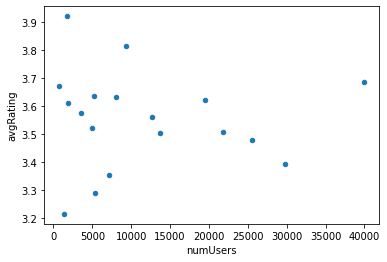

In [20]:
# 장르별 평균 평점 산포도
genre_statistics.plot.scatter(x='numUsers', y='avgRating')

In [21]:
# Genre 별 steamRating을 이용해 Top 10 구하기
genre = 'Action'

movie_statistics_with_genre = pd.merge(movie_statistics, movies_df, how='inner', on='movie_id')
top10_df_genre = movie_statistics_with_genre[movie_statistics_with_genre[genre] == 1]\
                    .sort_values(by='steamRating', ascending=False)[:10]
top10_df_genre

,movie_id,numUsers,avgRating,stdRating,steamRating,score,movie_title,release_date,video_release_date,IMDb_URL,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
49,50,583,4.358491,0.881341,4.158731,1038.844786,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,...,0,0,0,0,0,1,1,0,1,0
126,127,413,4.283293,0.934577,4.073956,745.770461,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",...,0,0,0,0,0,0,0,0,0,0
173,174,420,4.252381,0.891819,4.049117,757.974657,Raiders of the Lost Ark (1981),01-Jan-1981,NaN,http://us.imdb.com/M/title-exact?Raiders%20of%...,...,0,0,0,0,0,0,0,0,0,0
312,313,350,4.245714,0.946822,4.032126,635.329245,Titanic (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,...,0,0,0,0,0,1,0,0,0,0
171,172,367,4.204360,0.922803,4.000789,665.241548,"Empire Strikes Back, The (1980)",01-Jan-1980,NaN,http://us.imdb.com/M/title-exact?Empire%20Stri...,...,0,0,0,0,0,1,1,0,1,0
172,173,324,4.172840,0.998948,3.967019,589.412998,"Princess Bride, The (1987)",01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Princess%20Br...,...,0,0,0,0,0,1,0,0,0,0
514,515,201,4.203980,0.901767,3.960037,369.065495,"Boot, Das (1981)",04-Apr-1997,NaN,"http://us.imdb.com/M/title-exact?Boot,%20Das%2...",...,0,0,0,0,0,0,0,0,1,0
186,187,209,4.186603,0.919141,3.948989,383.573050,"Godfather: Part II, The (1974)",01-Jan-1974,NaN,http://us.imdb.com/M/title-exact?Godfather:%20...,...,0,0,0,0,0,0,0,0,0,0
21,22,297,4.151515,0.962440,3.944074,541.504651,Braveheart (1995),16-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Braveheart%20...,...,0,0,0,0,0,0,0,0,1,0
497,498,152,4.184211,0.758362,3.923218,279.585197,"African Queen, The (1951)",01-Jan-1951,NaN,http://us.imdb.com/M/title-exact?African%20Que...,...,0,0,0,0,0,1,0,0,1,0


### 사용자 데모그래픽을 활용한 추천

In [22]:
demo_ratings_df = pd.merge(ratings_df, users_df, how='inner', on='user_id')

def age_map(x):
    if x < 20:
        return 10
    elif 20 <= x and x < 30:
        return 20
    elif 30 <= x and x < 40:
        return 30
    elif 40 <= x and x < 50:
        return 40
    else:
        return 50

demo_ratings_df['age'] = demo_ratings_df['age'].apply(lambda x: age_map(x))

# 영화 ranking을 위한 영화별 통계량 계산

demo_movie_statistics = pd.DataFrame({
    'numUsers': demo_ratings_df.groupby(['gender', 'age', 'movie_id'])['user_id'].nunique(),
    'avgRating': demo_ratings_df.groupby(['gender', 'age', 'movie_id'])['rating'].mean(), 
    'stdRating': demo_ratings_df.groupby(['gender', 'age', 'movie_id'])['rating'].std()
}).reset_index()

demo_movie_statistics.head()

,gender,age,movie_id,numUsers,avgRating,stdRating
0,F,10,1,13,3.769231,1.091928
1,F,10,2,2,3.000000,1.414214
2,F,10,3,1,5.000000,NaN
3,F,10,4,2,2.500000,0.707107
4,F,10,5,2,4.500000,0.707107


In [23]:
# Steam Rating
demo_movie_statistics['steamRating'] = demo_movie_statistics['avgRating'] \
                                        - (demo_movie_statistics['avgRating'] - 3.0) * np.power(2, -np.log10(demo_movie_statistics['numUsers']))


In [24]:
# 30대 남자
gender = 'M'
age = 30

filter_df = demo_movie_statistics[(demo_movie_statistics['gender'] == gender) & (demo_movie_statistics['age'] == age)]
top10_df = filter_df.sort_values(by='steamRating')[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,gender,age,movie_id,numUsers,avgRating,stdRating,steamRating,movie_title,release_date
0,M,30,1215,10,1.600000,0.699206,2.300000,Barb Wire (1996),03-May-1996
1,M,30,688,8,1.500000,1.069045,2.302110,Leave It to Beaver (1997),22-Aug-1997
2,M,30,457,5,1.200000,0.447214,2.308821,Free Willy 3: The Rescue (1997),08-Aug-1997
3,M,30,383,5,1.200000,0.447214,2.308821,"Flintstones, The (1994)",01-Jan-1994
4,M,30,948,10,1.700000,0.948683,2.350000,Booty Call (1997),28-Feb-1997
5,M,30,325,23,1.956522,1.065076,2.362556,Crash (1996),21-Mar-1997
6,M,30,368,5,1.400000,0.894427,2.385619,Bio-Dome (1996),01-Jan-1996
7,M,30,1013,5,1.400000,0.547723,2.385619,Anaconda (1997),11-Apr-1997
8,M,30,120,15,1.933333,0.883715,2.405385,Striptease (1996),28-Jun-1996
9,M,30,1234,3,1.000000,0.000000,2.436819,Chairman of the Board (1998),01-Jan-1998


In [25]:
# 40대 여자
gender = 'F'
age = 20

filter_df = demo_movie_statistics[(demo_movie_statistics['gender'] == gender) & (demo_movie_statistics['age'] == age)]
top10_df = filter_df.sort_values(by='steamRating')[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,gender,age,movie_id,numUsers,avgRating,stdRating,steamRating,movie_title,release_date
0,F,20,569,5,1.400000,0.894427,2.385619,Wolf (1994),01-Jan-1994
1,F,20,669,4,1.250000,0.500000,2.402922,Body Parts (1991),01-Jan-1991
2,F,20,590,3,1.000000,0.000000,2.436819,Hellraiser: Bloodline (1996),08-Mar-1996
3,F,20,545,3,1.000000,0.000000,2.436819,Vampire in Brooklyn (1995),01-Jan-1995
4,F,20,1079,5,1.600000,1.341641,2.462417,Joe's Apartment (1996),26-Jul-1996
5,F,20,997,4,1.500000,1.000000,2.488219,Stuart Saves His Family (1995),01-Jan-1995
6,F,20,1229,4,1.500000,0.577350,2.488219,Poison Ivy II (1995),01-Jan-1995
7,F,20,743,4,1.500000,0.577350,2.488219,"Crow: City of Angels, The (1996)",30-Aug-1996
8,F,20,554,7,1.857143,0.899735,2.493341,Waterworld (1995),01-Jan-1995
9,F,20,240,12,2.083333,0.996205,2.517189,Beavis and Butt-head Do America (1996),20-Dec-1996


In [26]:
for gender in ['M', 'F']:
    for age in [10, 20, 30, 40, 50, 60]:
        filter_df = demo_movie_statistics[(demo_movie_statistics['gender'] == gender) & (demo_movie_statistics['age'] == age)]
        top10_df = filter_df.sort_values(by = 'steamRating', ascending=False)[:10]
        print(gender, age)
        print(pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on ='movie_id')['movie_title'].values)

M 10
['Star Wars (1977)' 'Empire Strikes Back, The (1980)'
 'Return of the Jedi (1983)' 'Shawshank Redemption, The (1994)'
 'Good Will Hunting (1997)' 'Usual Suspects, The (1995)' 'Clerks (1994)'
 'Godfather, The (1972)' 'Godfather: Part II, The (1974)'
 'Casablanca (1942)']
M 20
['Shawshank Redemption, The (1994)' 'Star Wars (1977)'
 'Godfather, The (1972)' 'Silence of the Lambs, The (1991)'
 'Usual Suspects, The (1995)' 'Empire Strikes Back, The (1980)'
 'Princess Bride, The (1987)' 'Raiders of the Lost Ark (1981)'
 'Titanic (1997)' 'Casablanca (1942)']
M 30
['Casablanca (1942)' 'Star Wars (1977)'
 "One Flew Over the Cuckoo's Nest (1975)" 'Rear Window (1954)'
 'North by Northwest (1959)' 'Godfather, The (1972)'
 'Raiders of the Lost Ark (1981)' "Schindler's List (1993)"
 'Usual Suspects, The (1995)' 'Raging Bull (1980)']
M 40
['Casablanca (1942)' "Schindler's List (1993)" 'Wizard of Oz, The (1939)'
 'Usual Suspects, The (1995)' 'Shawshank Redemption, The (1994)'
 'Ran (1985)' 'Vertig

# 추천 시스템을 만들고 평가
1. 데이터를 `train` / `test`로 나눔
2. `train` 데이터를 이용해 추천 모델/시스템을 만들고 `test` 데이터로 평가
3. 평가 `지표`에 따라 **1)** 추천 결과의 형태가 달라지거나, **2)** `train`/`test` 데이터를 나누는 방법이 달라짐

## 무비렌즈 데이터 Load

In [27]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
path = '/content/drive/MyDrive/MyLecture/2022/BigData2022/Scoring/'

In [ ]:
ratings_df = pd.read_csv(path + 'u.data', sep='\t', encoding='latin-1', header=None)
ratings_df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
users_df = pd.read_csv(path + 'u.user', sep='|', encoding='latin-1', header=None)
users_df.columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

In [ ]:
print(ratings_df.shape)
print(ratings_df.head())

(100000, 4)
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596


## Top K Recommendation

- 사용자 또는 세션별로 Top K 추천 결과를 생성하여 추천 성능을 평가
- 구해볼 `지표`는 아래와 같습니다

    1. Precision/Recall
    2. MAP
    3. NDCG
    4. Hit Ratio

- 현재 주어진 `무비렌즈 데이터`의 경우, 사용자의 영화에 대한 평점 데이터로 이뤄졌습니다
- 위의 평가 `지표`를 구하기 위해서는 사용자에게 영화가 추천되었을 때, 사용자가 이 영화에 관련이 있는지 아닌지에 대한 기준이 필요합니다
- **즉, 사용자가 영화를 선호한다는 정의는 `4.0`점 이상 평가를 내린 것으로 가정**
- Top K 추천 결과 생성은 앞서 배운 `Steam` 로지긍ㄹ 사용한 평균 평점 기반 추천 로직을 사용하고, 이를 통해 `지표`를 직접 구해봅니다.

### 추천 성능 평가를 위한 test data와 predict data 생성


먼저 학습 데이터를 `train`, `test` 데이터로 나눕니다.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(80000, 4)
(20000, 4)


평균 평점 기반 추천을 위한 영화별 통계량

In [ ]:
movie_statistics = pd.DataFrame({
    'numUsers' : train_df.groupby('movie_id')['user_id'].nunique(),
    'avgRating' : train_df.groupby('movie_id')['rating'].mean(),
    'stdRating' : train_df.groupby('movie_id')['rating'].std()
}).reset_index()

movie_statistics.head()

,movie_id,numUsers,avgRating,stdRating
0,1,349,3.865330,0.917064
1,2,103,3.203883,0.973766
2,3,69,3.101449,1.189969
3,4,173,3.549133,0.960960
4,5,69,3.246377,0.881272


다음은 `Steam` Rating을 구해봅니다.

In [ ]:
movie_statistics['steamRating'] = movie_statistics['avgRating'] - (movie_statistics['avgRating'] - 3.0) \
                                    * np.power(2, -np.log10(movie_statistics['numUsers']))
topk_df = movie_statistics.sort_values(by='steamRating', ascending=False)
topk_df

,movie_id,numUsers,avgRating,stdRating,steamRating
317,318,236,4.474576,0.779655,4.189901
63,64,228,4.456140,0.758393,4.172091
49,50,451,4.370288,0.865591,4.152605
482,483,189,4.428571,0.744789,4.133710
11,12,219,4.410959,0.821203,4.132366
...,...,...,...,...,...
437,438,6,1.166667,0.408248,2.235708
436,437,5,1.000000,0.000000,2.232024
687,688,38,1.842105,1.078696,2.229458
456,457,18,1.611111,1.092159,2.192937


### 평가 지표


#### Precsion/Recall@K/MAP

여기서 `recommend의 길이`가 `@K`를 의미합니다

In [ ]:
 # True라고 예측한 것들 가운데 실제 True 비율
 def get_precision(relevant, recommend):
     _intersection = set(recommend).intersection(set(relevant)) # set(recommend) & set(relevant)
     return len(_intersection) / len(recommend)

# 전체 True 가운데 True라고 예측한 비율
def get_recall(relevant, recommend):
    _intersection = set(recommend).intersection(set(relevant))
    return len(_intersection) / len(relevant) 

# Precision@1부터 Precision@K 까지의 평균값
def get_avergae_precision(relevant, recommend):
    _precisions = []
    
    for i in range(len(recommend)):
        _recommend = recommend[:i+1]
        _precisions.append(get_precision(relevant, _recommend))
    
    return np.mean(_precisions)


개별 사용자에 대해서 추천을 수행하고 각 지표를 구한 뒤에 이를 합칩니다.

In [ ]:
test_user_set = set(test_df['user_id'].unique())

k = 10

recommend_item = topk_df['movie_id'][:k].tolist()

precisions = []
recalls = []
average_precisions = []

for user_id in list(test_user_set):
    # 해당 유저가 평점 4.0 이상 추천한 영화 정보
    test_user_rating_df = test_df[(test_df['user_id'] == user_id) & (test_df['rating'] >= 4.0)]
    relevant_item = test_user_rating_df.sort_values(by='rating', ascending=False)['movie_id'].tolist()

    # 테스트 데이터에 있는 유저 가운데 선호 영화가 아예 없는 경우
    if len(relevant_item) <= 0:
        continue
    
    # precision@K
    precision = get_precision(relevant_item, recommend_item)
    precisions.append(precision)

    # recall@K
    recall = get_recall(relevant_item, recommend_item)
    recalls.append(recall)

    # MAP@K
    average_precision = get_precision(relevant_item, recommend_item)
    average_precisions.append(average_precision)

print('precision@K :', np.mean(precisions))
print('recall@K :', np.mean(recalls))
print('MAP@K :', np.mean(average_precisions))

precision@K : 0.05521739130434782
recall@K : 0.04638027062611089
MAP@K : 0.05521739130434782


In [ ]:
print(len(test_user_set))
print(len(precisions))

940
920


#### NDCG


In [28]:
# 특정 사용자에 대해서 5개의 아이템이 추천되었을 때,
relevant_item = ['a', 'b', 'c']
recommend_item = ['d', 'c', 'a', 'b', 'e']
k = len(recommend_item)

# Cumulative Gain 구하기 - 맞출 때마다 고려
cg = []
for item in recommend_item:
    if item in relevant_item:
        cg.append(1)
    else:
        cg.append(0)
cg

[0, 1, 1, 1, 0]

##### DCG
$DCG_{K}=\sum_{i=1}^{K}\frac{rel_{i}}{log_{2}(i+1)}$
- 순서에 따라 log 값으로 나눠 Cumulative Gain을 Discount

In [ ]:
discount = np.log2(np.arange(k) + 2)
discount

# discounted cg 구하기
dcg = np.sum(np.divide(cg, discount))
dcg

1.5616063116448506

##### IDCG
$IDCG = \sum_{i=1}^{K}\frac{rel_{i}^{opt}}{log_{2}(i+1)}$
- 이상적인 추천이 일어났을 때의 DCG 값
- 가능한 DCG 값 중에 제일 큶

In [ ]:
k_for_icg = min(k, len(relevant_item))
icg = np.zeros(k)
for i in range(k_for_icg):
    icg[i] += 1
icg

array([1., 1., 1., 0., 0.])

In [ ]:
# ideal dcg 구하기
idcg = np.sum(np.divide(icg, discount))
idcg

2.1309297535714578

$NDCG = \frac{DCG}{IDCG}$
- 추천 결과에 따라 구해진 `DCG`를 `IDCG`로 나눈 값 $\to$ **최대 값은 1이다.**

In [ ]:
# NDCG
ndcg = dcg / idcg
ndcg

0.7328286204777911

#### 실습
k개의 아이템이 추천되었을 때 값을 구합니다.

In [ ]:
def get_ndcg(relevant_item, recommend_item):
    k = len(recommend_item)
    discount = np.log2(np.arange(k) + 2)
    cg = []
    for item in recommend_item:
        if item in relevant_item:
            cg.append(1)
        else:
            cg.append(0)
    
    dcg = np.sum(np.divide(cg, discount))

    k_for_icg = min(k, len(relevant_item))
    icg = np.zeros(k)
    for i in range(k_for_icg):
        icg[i] += 1
    idcg = np.sum(np.divide(icg, discount))
    
    return dcg / idcg

In [ ]:
relevant_item = ['a', 'b', 'd', 'f']
recommend_item = ['d', 'c', 'a', 'b', 'e']
get_ndcg(relevant_item, recommend_item)

0.75369761125927

개별 사용자에 대해서 추천을 수행하고, 각 지표를 구한 뒤에 이를 합칩니다.

In [ ]:
k = 10

recommend_item = topk_df['movie_id'][:k].tolist()

ndcgs = []

for user_id in list(test_user_set):
    
    test_user_rating_df = test_df[(test_df['user_id'] == user_id) & (test_df['rating'] >= 4.0)]
    relevant_item = test_user_rating_df.sort_values(by='rating', ascending=False)['movie_id'].tolist()
    
    # 테스트 데이터에 있는 유저 가운데 선호 영화가 아예 없는 케이스도 존재함. (4.0이상 평가한 영화가 아예 없는 유저)
    if len(relevant_item) == 0:
        continue
        
    # ndcg@k
    ndcg = get_ndcg(relevant_item, recommend_item)
    ndcgs.append(ndcg)

print("ndcg@k: ", np.mean(ndcgs))

ndcg@k:  0.06425144137326387


* relevant item, 추천 아이템 뽑아 내는 것이 중요